In [ ]:
!pip install python-Levenshtein
!pip install distance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=1313a47339988019b2c724c4035448c10957ea00d33b7c8d66cf7af127ca76d3
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


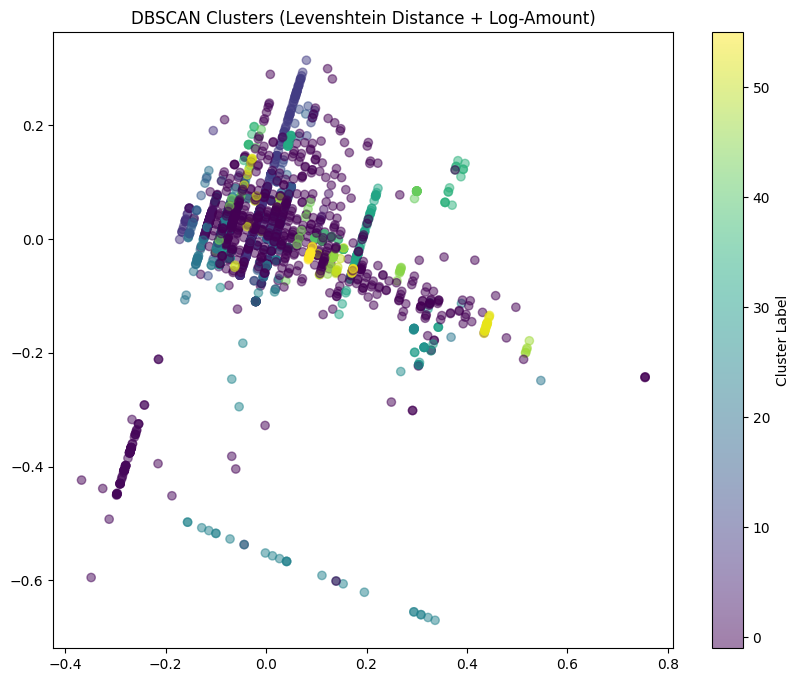

Cluster 0:
Merchant: Paypal, Amount: 5.0, Notes: nan
Merchant: Paypal, Amount: 6.0, Notes: nan
Merchant: Paypal, Amount: 1.04, Notes: nan
Merchant: Paypal, Amount: 182.0, Notes: nan
Merchant: Paypal, Amount: 182.0, Notes: nan
Merchant: Paypal, Amount: 1.75, Notes: nan
Merchant: Paypal, Amount: 0.96, Notes: nan
Merchant: Paypal, Amount: 5.0, Notes: nan
Merchant: Paypal, Amount: 6.0, Notes: nan
Merchant: Paypal, Amount: 4.95, Notes: nan
Noise Points: 637
Cluster 1:
Merchant: GoFood, Amount: 39800.0, Notes: nan
Merchant: GoFood, Amount: 39800.0, Notes: nan
Merchant: GoFood, Amount: 51000.0, Notes: nan
Merchant: GoFood, Amount: 23500.0, Notes: nan
Merchant: GoFood, Amount: 22800.0, Notes: nan
Merchant: GoFood, Amount: 35000.0, Notes: nan
Merchant: GoFood, Amount: 107000.0, Notes: nan
Merchant: GoFood, Amount: 250000.0, Notes: nan
Merchant: GoFood, Amount: 55400.0, Notes: nan
Merchant: GoFood, Amount: 23800.0, Notes: nan
Cluster 2:
Merchant: FLIPTECH LENTERA INS, Amount: 65217.0, Notes: -
M

In [ ]:
import pandas as pd
import numpy as np
import Levenshtein  # Menggunakan python-Levenshtein untuk menghitung Levenshtein distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import defaultdict

# 1. Load data dan preprocessing
csv_file_path = "merge-csv-training.csv"
df = pd.read_csv(csv_file_path, sep=";", on_bad_lines="skip")

# Pastikan kolom yang dibutuhkan ada
if "Merchant Name" not in df.columns or "Notes" not in df.columns or "Amount" not in df.columns:
    raise ValueError("CSV file harus mengandung kolom 'Merchant Name', 'Notes', dan 'Amount'")

# Pastikan Merchant Name dan Notes adalah string, dan isi NaN dengan string kosong
df["Merchant Name"] = df["Merchant Name"].astype(str).fillna("")
df["Notes"] = df["Notes"].astype(str).fillna("")

# 2. Log Transformation of Amount
df["Log_Amount"] = np.log10(df["Amount"].replace(0, np.nan)).fillna(0)

# 3. Menghitung Levenshtein Distance antar Merchant Name dan Notes
def compute_levenshtein_distance(row):
    # Pastikan bahwa 'Merchant Name' dan 'Notes' adalah string yang valid
    return Levenshtein.distance(row['Merchant Name'], row['Notes'])

# Tambahkan kolom Levenshtein Distance
df["Levenshtein_Dist"] = df.apply(compute_levenshtein_distance, axis=1)

# 4. Normalisasi Levenshtein Distance dan Log-Amount
scaler = MinMaxScaler()
log_amount_normalized = scaler.fit_transform(df["Log_Amount"].values.reshape(-1, 1))
levenshtein_normalized = scaler.fit_transform(df["Levenshtein_Dist"].values.reshape(-1, 1))

# 5. Gabungkan fitur untuk clustering
# Gabungkan Log-Amount yang sudah dinormalisasi dan Levenshtein Distance yang sudah dinormalisasi
features = np.hstack([log_amount_normalized, levenshtein_normalized])

# 6. Buat matriks jarak menggunakan Levenshtein Distance
# Ini adalah matriks jarak precomputed untuk digunakan dengan DBSCAN
levenshtein_matrix = np.array([[Levenshtein.distance(x1, x2) for x1 in df['Merchant Name']] for x2 in df['Merchant Name']])

# 7. Apply DBSCAN Clustering dengan jarak kustom
# Gunakan DBSCAN dengan `metric="precomputed"` karena kita menggunakan matriks jarak
dbscan = DBSCAN(metric="precomputed", eps=0.5, min_samples=5)
dbscan.fit(levenshtein_matrix)  # Gunakan matriks Levenshtein

# 8. Visualisasikan cluster
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.title("DBSCAN Clusters (Levenshtein Distance + Log-Amount)")
plt.colorbar(label='Cluster Label')
plt.show()

# 9. Analisis Hasil Cluster
clusters = defaultdict(list)
for i, label in enumerate(dbscan.labels_):
    clusters[label].append(df.iloc[i])

# Menampilkan cluster
for cluster_id, cluster_data in clusters.items():
    if cluster_id != -1:  # -1 menunjukkan noise
        print(f"Cluster {cluster_id}:")
        for transaction in cluster_data[:10]:  # Tampilkan 10 transaksi pertama per cluster
            print(f"Merchant: {transaction['Merchant Name']}, Amount: {transaction['Amount']}, Notes: {transaction['Notes']}")
    else:
        print(f"Noise Points: {len(cluster_data)}")

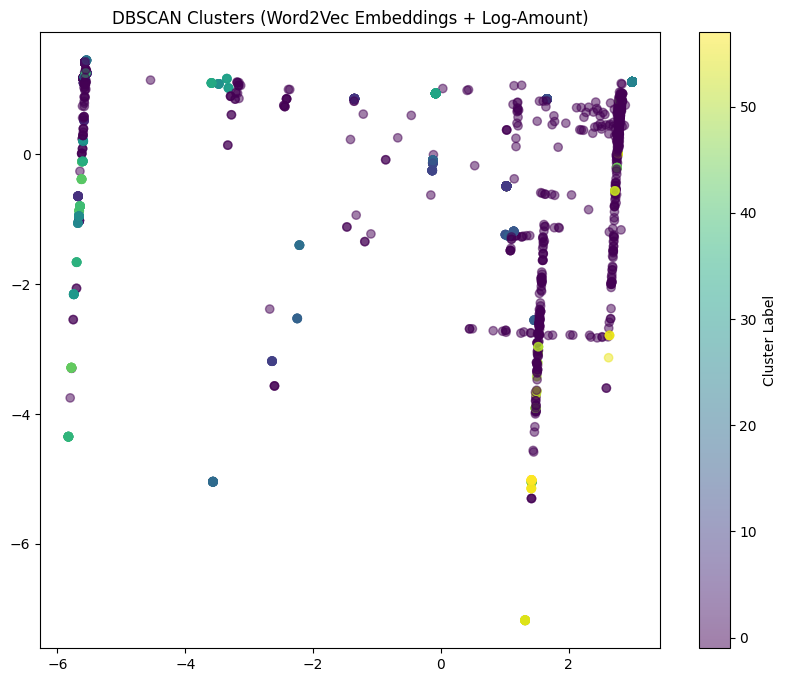

Cluster 0:
Merchant: Paypal, Amount: 5.0, Notes: -
Merchant: Paypal, Amount: 6.0, Notes: -
Merchant: Paypal, Amount: 1.04, Notes: -
Merchant: Paypal, Amount: 182.0, Notes: -
Merchant: Paypal, Amount: 182.0, Notes: -
Merchant: Paypal, Amount: 1.75, Notes: -
Merchant: Paypal, Amount: 0.96, Notes: -
Merchant: Paypal, Amount: 5.0, Notes: -
Merchant: Paypal, Amount: 6.0, Notes: -
Merchant: Paypal, Amount: 4.95, Notes: -
Noise Points: 701
Cluster 1:
Merchant: GoFood, Amount: 39800.0, Notes: -
Merchant: GoFood, Amount: 39800.0, Notes: -
Merchant: GoFood, Amount: 51000.0, Notes: -
Merchant: GoFood, Amount: 23500.0, Notes: -
Merchant: GoFood, Amount: 22800.0, Notes: -
Merchant: GoFood, Amount: 35000.0, Notes: -
Merchant: GoFood, Amount: 107000.0, Notes: -
Merchant: GoFood, Amount: 250000.0, Notes: -
Merchant: GoFood, Amount: 55400.0, Notes: -
Merchant: GoFood, Amount: 23800.0, Notes: -
Cluster 2:
Merchant: FLIPTECH LENTERA INS, Amount: 65217.0, Notes: -
Merchant: FLIPTECH LENTERA INS, Amount: 5

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# 1. Load the Data
csv_file_path = "merge-extracted-email.csv"
df = pd.read_csv(csv_file_path, sep=";", on_bad_lines="skip")

# Pastikan kolom yang dibutuhkan ada
if "Merchant Name" not in df.columns or "Notes" not in df.columns or "Amount" not in df.columns:
    raise ValueError("CSV file harus mengandung kolom 'Merchant Name', 'Notes', dan 'Amount'")

# Pastikan Merchant Name dan Notes adalah string
df["Merchant Name"] = df["Merchant Name"].astype(str).fillna("")
df["Notes"] = df["Notes"].fillna("-")

# 2. Tokenize the Text Data
# Fungsi untuk melakukan tokenisasi sederhana
def tokenize(text):
    return text.lower().split()

df['Merchant_Tokens'] = df['Merchant Name'].apply(tokenize)
df['Notes_Tokens'] = df['Notes'].apply(tokenize)

# 3. Train Word2Vec Model
# Menggabungkan token dari 'Merchant Name' dan 'Notes' untuk membangun Word2Vec
all_tokens = df['Merchant_Tokens'].tolist() + df['Notes_Tokens'].tolist()

# Train Word2Vec model
model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

# 4. Modified get_average_embedding function to handle the Word2Vec model
def get_average_embedding(tokens, model):
    # Initialize an empty list to store the word embeddings
    embeddings = []

    # Iterate through each token and get its corresponding embedding from the Word2Vec model
    for word in tokens:
        if word in model.wv:  # Ensure the word exists in the model's vocabulary
            embeddings.append(model.wv[word])

    # If no valid embeddings are found, return a zero vector
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)

    # Return the average embedding (mean of word vectors)
    return np.mean(embeddings, axis=0)

# 5. Mendapatkan Embedding untuk Merchant Name dan Notes
df['Merchant_Embedding'] = df['Merchant_Tokens'].apply(lambda x: get_average_embedding(x, model))
df['Notes_Embedding'] = df['Notes_Tokens'].apply(lambda x: get_average_embedding(x, model))

# 6. Gabungkan Embedding Merchant Name dan Notes
combined_embeddings = np.array([np.concatenate([merchant, notes]) for merchant, notes in zip(df['Merchant_Embedding'], df['Notes_Embedding'])])

# 7. Normalisasi Data
scaler = MinMaxScaler()
normalized_embeddings = scaler.fit_transform(combined_embeddings)

# 8. DBSCAN Clustering dengan Metric Euclidean
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan.fit(normalized_embeddings)

# 9. Visualisasi Cluster (menggunakan PCA untuk reduksi dimensi)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.title("DBSCAN Clusters (Word2Vec Embeddings + Log-Amount)")
plt.colorbar(label='Cluster Label')
plt.show()

# 10. Analisis Hasil Cluster
clusters = defaultdict(list)
for i, label in enumerate(dbscan.labels_):
    clusters[label].append(df.iloc[i])

# Menampilkan cluster
for cluster_id, cluster_data in clusters.items():
    if cluster_id != -1:  # -1 menunjukkan noise
        print(f"Cluster {cluster_id}:")
        for transaction in cluster_data[:10]:  # Tampilkan 10 transaksi pertama per cluster
            print(f"Merchant: {transaction['Merchant Name']}, Amount: {transaction['Amount']}, Notes: {transaction['Notes']}")
    else:
        print(f"Noise Points: {len(cluster_data)}")

In [ ]:
import nltk

# First, download the punkt resource again explicitly
nltk.download('tokenizers')
nltk.download('punkt_tab')

# Now let's verify it's correctly installed by checking
print(nltk.data.find('./tokenizers/punkt_tab'))

# Proceed with the rest of your code
from nltk.tokenize import word_tokenize

import pandas as pd
import numpy as np
import gensim
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import nltk

# Download necessary resources from NLTK
nltk.download('punkt')

# Tokenize function
def tokenize(text):
    return text.lower().split()

# Function to get average embedding for tokens using Word2Vec
def get_average_embedding(tokens, model):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:  # If there are words found in the model
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # If no word found, return zero vector

# 1. Load Data
csv_file_path = "merge-extracted-email.csv"
df = pd.read_csv(csv_file_path, sep=";", on_bad_lines="skip")

# Make sure the necessary columns exist
if "Merchant Name" not in df.columns or "Notes" not in df.columns or "Amount" not in df.columns:
    raise ValueError("CSV file must contain 'Merchant Name', 'Notes', and 'Amount' columns.")

# Ensure 'Merchant Name' and 'Notes' columns are strings
df["Merchant Name"] = df["Merchant Name"].astype(str).fillna("")
df["Notes"] = df["Notes"].fillna("-")

# Tokenize Merchant Name and Notes
df['Merchant_Tokens'] = df['Merchant Name'].apply(tokenize)
df['Notes_Tokens'] = df['Notes'].apply(tokenize)

# 2. Train Word2Vec Model
sentences = df['Merchant_Tokens'].tolist() + df['Notes_Tokens'].tolist()
word2vec_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# 3. Process Amount and Fit Normalizer
scaler_amount = MinMaxScaler()
df['Log_Amount'] = np.log10(df['Amount'].replace(0, np.nan).fillna(1))  # Avoid log(0) by setting 0 to 1
scaler_amount.fit(df[['Log_Amount']])

# 4. Get Combined Embeddings for the Data
df['Merchant_Embedding'] = df['Merchant_Tokens'].apply(lambda x: get_average_embedding(x, word2vec_model))
df['Notes_Embedding'] = df['Notes_Tokens'].apply(lambda x: get_average_embedding(x, word2vec_model))

# Combine Merchant and Notes embeddings
combined_embeddings = np.array([np.concatenate([merchant, notes])
                                for merchant, notes in zip(df['Merchant_Embedding'], df['Notes_Embedding'])])

# Normalize combined embeddings (excluding the 'Amount')
scaler = MinMaxScaler()
normalized_embeddings = scaler.fit_transform(combined_embeddings)

# 5. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')  # Using cosine metric for DBSCAN
dbscan.fit(normalized_embeddings)

# 6. Function to Process New Data (Merchant Name, Notes, Amount)
def process_new_data(new_merchant, new_notes, new_amount, scaler_amount, model):
    # Tokenize new data
    new_merchant_tokens = tokenize(new_merchant)
    new_notes_tokens = tokenize(new_notes)

    # Get embeddings for Merchant Name and Notes using Word2Vec
    new_merchant_embedding = get_average_embedding(new_merchant_tokens, model)
    new_notes_embedding = get_average_embedding(new_notes_tokens, model)

    # Combine the embeddings for Merchant Name and Notes
    new_combined_embedding = np.concatenate([new_merchant_embedding, new_notes_embedding])

    # Normalize the Word2Vec part (combine Merchant + Notes embeddings)
    new_combined_embedding_normalized = scaler.transform([new_combined_embedding])[0]

    # Normalize the Amount (same process as for the dataset)
    log_amount = np.log10(new_amount if new_amount > 0 else 1)  # Avoid log(0) by setting 0 to 1
    normalized_amount = scaler_amount.transform([[log_amount]])[0][0]  # Normalize using pre-fitted scaler

    # Combine the normalized Word2Vec embeddings with the normalized amount
    new_combined_embedding_with_amount = np.concatenate([new_combined_embedding_normalized, [normalized_amount]])

    return new_combined_embedding_with_amount, new_combined_embedding_normalized  # Return both embeddings

# 7. Process New Data for Clustering
new_merchant_name = "Chatime - Gunung Sari"
new_notes = "GrabFood Order"
new_amount = 51000
new_data_embedding, new_combined_embedding_normalized = process_new_data(new_merchant_name, new_notes, new_amount, scaler_amount, word2vec_model)

# Cosine Similarity with existing dataset embeddings (use the normalized Word2Vec part only)
cosine_similarities = cosine_similarity([new_combined_embedding_normalized], normalized_embeddings)
most_similar_index = np.argmax(cosine_similarities)

# Predicted cluster using DBSCAN
predicted_cluster = dbscan.labels_[most_similar_index]

# Check for noise
if predicted_cluster == -1:
    print("The new data is considered an outlier (Noise).")
else:
    print(f"Predicted cluster for the new data: {predicted_cluster}")
    print("Most similar existing transaction:")
    print(df.iloc[most_similar_index])

    # Optionally: Display all transactions from the predicted cluster
    predicted_cluster_transactions = df[dbscan.labels_ == predicted_cluster]
    print("\nTransactions in the predicted cluster:")
    print(predicted_cluster_transactions)

[nltk_data] Error loading tokenizers: Package 'tokenizers' not found
[nltk_data]     in index
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


/root/nltk_data/tokenizers/punkt_tab


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Predicted cluster for the new data: 0
Most similar existing transaction:
Datetime                                               31/01/2024 10:15
Merchant Name                       Bubur Ayam Mezem - Penjaringan Sari
Sub Category                                                        NaN
Category                                                           FOOD
Amount                                                          33500.0
Currency                                                            IDR
Transaction Type                                                EXPENSE
Payment Method                                                      OVO
Transaction ID                                                      NaN
Notes                                                    GrabFood Order
Merchant_Tokens              [bubur, ayam, mezem, -, penjaringan, sari]
Notes_Tokens                                          [grabfood, order]
Log_Amount                                                     

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


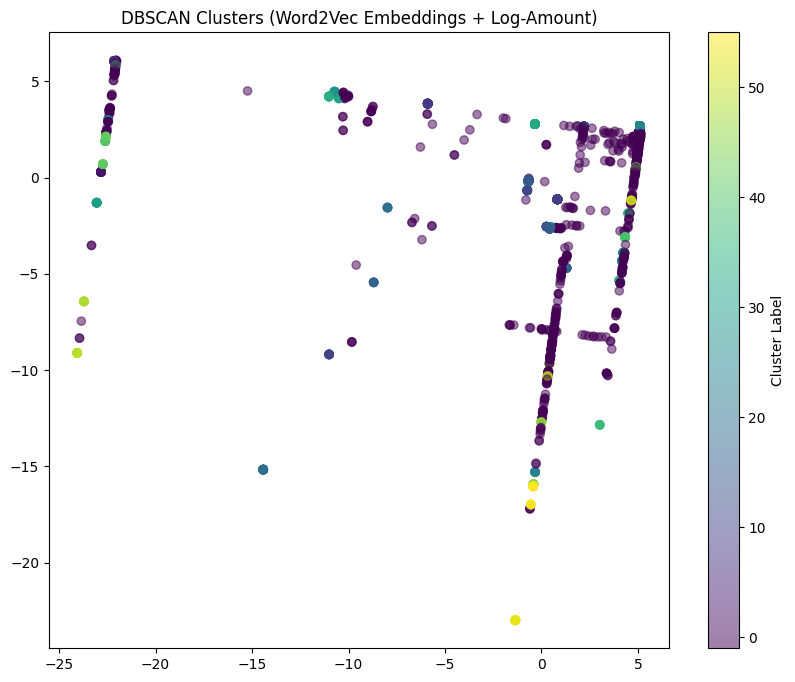

Cluster 0:
Merchant: Paypal, Amount: 5.0, Notes: nan
Merchant: Paypal, Amount: 6.0, Notes: nan
Merchant: Paypal, Amount: 1.04, Notes: nan
Merchant: Paypal, Amount: 182.0, Notes: nan
Merchant: Paypal, Amount: 182.0, Notes: nan
Merchant: Paypal, Amount: 1.75, Notes: nan
Merchant: Paypal, Amount: 0.96, Notes: nan
Merchant: Paypal, Amount: 5.0, Notes: nan
Merchant: Paypal, Amount: 6.0, Notes: nan
Merchant: Paypal, Amount: 4.95, Notes: nan
Noise Points: 722
Cluster 1:
Merchant: GoFood, Amount: 39800.0, Notes: nan
Merchant: GoFood, Amount: 39800.0, Notes: nan
Merchant: GoFood, Amount: 51000.0, Notes: nan
Merchant: GoFood, Amount: 23500.0, Notes: nan
Merchant: GoFood, Amount: 22800.0, Notes: nan
Merchant: GoFood, Amount: 35000.0, Notes: nan
Merchant: GoFood, Amount: 107000.0, Notes: nan
Merchant: GoFood, Amount: 250000.0, Notes: nan
Merchant: GoFood, Amount: 55400.0, Notes: nan
Merchant: GoFood, Amount: 23800.0, Notes: nan
Cluster 2:
Merchant: FLIPTECH LENTERA INS, Amount: 65217.0, Notes: -
M

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# 1. Load the Data
csv_file_path = "merge-extracted-email.csv"
df = pd.read_csv(csv_file_path, sep=";", on_bad_lines="skip")

# Pastikan kolom yang dibutuhkan ada
if "Merchant Name" not in df.columns or "Notes" not in df.columns or "Amount" not in df.columns:
    raise ValueError("CSV file harus mengandung kolom 'Merchant Name', 'Notes', dan 'Amount'")

# Pastikan Merchant Name dan Notes adalah string
df["Merchant Name"] = df["Merchant Name"].astype(str).fillna("")
df["Notes"] = df["Notes"].astype(str).fillna("-")

# 2. Tokenize the Text Data
# Fungsi untuk melakukan tokenisasi sederhana
def tokenize(text):
    return text.lower().split()

df['Merchant_Tokens'] = df['Merchant Name'].apply(tokenize)
df['Notes_Tokens'] = df['Notes'].apply(tokenize)

# 3. Train Word2Vec Model
# Menggabungkan token dari 'Merchant Name' dan 'Notes' untuk membangun Word2Vec
all_tokens = df['Merchant_Tokens'].tolist() + df['Notes_Tokens'].tolist()

# Train Word2Vec model
model = Word2Vec(sentences=all_tokens, vector_size=1000, window=5, min_count=1, workers=4)

# 4. Fungsi untuk mengonversi teks menjadi embedding (rata-rata embedding dari kata-kata)
def get_average_embedding(tokens):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:  # Jika ada kata yang ditemukan di dalam model
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # Jika tidak ada kata yang ditemukan, kembalikan vektor nol

# 5. Mendapatkan Embedding untuk Merchant Name dan Notes
df['Merchant_Embedding'] = df['Merchant_Tokens'].apply(get_average_embedding)
df['Notes_Embedding'] = df['Notes_Tokens'].apply(get_average_embedding)

# 6. Gabungkan Embedding Merchant Name dan Notes
combined_embeddings = np.array([np.concatenate([merchant, notes]) for merchant, notes in zip(df['Merchant_Embedding'], df['Notes_Embedding'])])

# 7. Normalisasi Data
scaler = MinMaxScaler()
normalized_embeddings = scaler.fit_transform(combined_embeddings)

# 8. DBSCAN Clustering dengan Metric Euclidean
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan.fit(normalized_embeddings)

# 9. Visualisasi Cluster (menggunakan PCA untuk reduksi dimensi)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(normalized_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.title("DBSCAN Clusters (Word2Vec Embeddings + Log-Amount)")
plt.colorbar(label='Cluster Label')
plt.show()

# 10. Analisis Hasil Cluster
clusters = defaultdict(list)
for i, label in enumerate(dbscan.labels_):
    clusters[label].append(df.iloc[i])

# Menampilkan cluster
for cluster_id, cluster_data in clusters.items():
    if cluster_id != -1:  # -1 menunjukkan noise
        print(f"Cluster {cluster_id}:")
        for transaction in cluster_data[:10]:  # Tampilkan 10 transaksi pertama per cluster
            print(f"Merchant: {transaction['Merchant Name']}, Amount: {transaction['Amount']}, Notes: {transaction['Notes']}")
    else:
        print(f"Noise Points: {len(cluster_data)}")

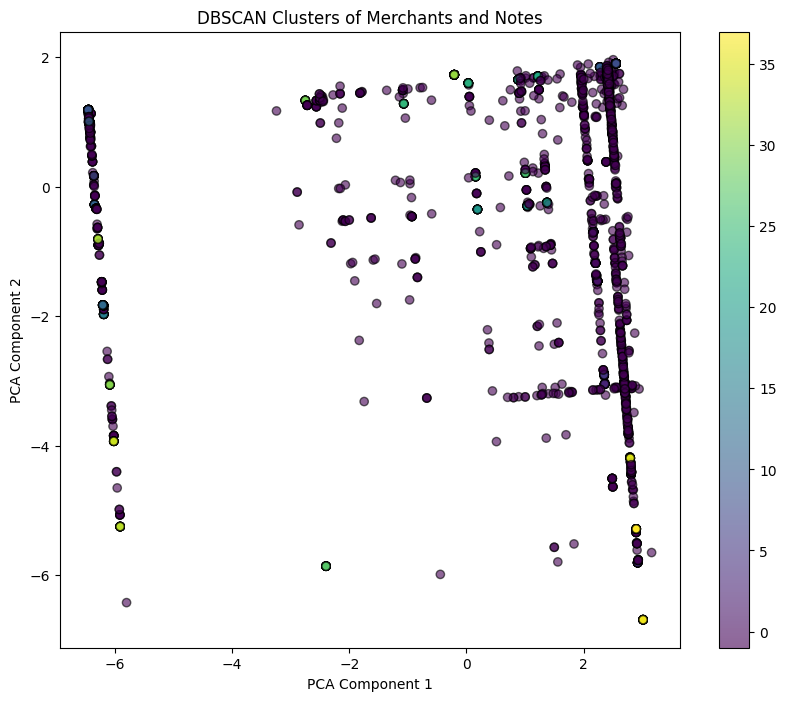

Cluster -1 contains 1385 entries.
         Merchant Name Notes   Amount
0       TBP Barbershop   OVO  50000.0
2       SOTO AYAM JAGO   OVO  20000.0
3  KITA KANTIN P DEPOT   OVO  20000.0
6             GAME BOX   OVO  12000.0
9   POK POK THE SQUARE   OVO  18000.0
Cluster 0 contains 18 entries.
    Merchant Name Notes   Amount
1     JUS OPA OYS   OVO   5000.0
18    JUS OPA OYS   OVO  12000.0
30    JUS OPA OYS   OVO  12000.0
98    JUS OPA OYS   OVO   7000.0
100   JUS OPA OYS   OVO  24000.0
Cluster 1 contains 34 entries.
   Merchant Name Notes   Amount
4    Dapur Mapan   OVO  22000.0
7    Dapur Mapan   OVO  29000.0
14   Dapur Mapan   OVO  22000.0
26   DAPUR MAPAN   OVO  22000.0
31   Dapur Mapan   OVO  25000.0
Cluster 2 contains 26 entries.
     Merchant Name Notes   Amount
5   NDOKEE EXPRESS   OVO  20000.0
10  NDOKEE EXPRESS   OVO  20000.0
21  NDOKEE EXPRESS   OVO  20000.0
23  NDOKEE EXPRESS   OVO  15000.0
33  NDOKEE EXPRESS   OVO  30000.0
Cluster 3 contains 21 entries.
              Mercha

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# 1. Load the Data
csv_file_path = "Cleaned_Email_Extraction.csv"
# Specify the separator explicitly and handle potential errors
try:
    df = pd.read_csv(csv_file_path, sep=";", on_bad_lines="skip")  # or sep=";" if your file uses semicolon
except pd.errors.ParserError as e:
    print(f"Error parsing CSV: {e}")
    # Optionally, print the problematic line:
    with open(csv_file_path, 'r') as file:
        for i, line in enumerate(file):
            if i == 46:  # Line 47 is index 46 (0-based)
                print(f"Problematic line: {line}")
                break

# Ensure required columns exist
if "Merchant Name" not in df.columns or "Notes" not in df.columns or "Amount" not in df.columns:
    raise ValueError("CSV file must contain 'Merchant Name', 'Notes', and 'Amount' columns")

# Ensure Merchant Name and Notes are string
df["Merchant Name"] = df["Merchant Name"].astype(str).fillna("")
df["Notes"] = df["Notes"].fillna("-")

# 2. Tokenize the Text Data
def tokenize(text):
    return text.lower().split()

df['Merchant_Tokens'] = df['Merchant Name'].apply(tokenize)
df['Notes_Tokens'] = df['Notes'].apply(tokenize)

# 3. Train Word2Vec Model
# Combine Merchant and Notes tokens into one list for training Word2Vec model
all_tokens = df['Merchant_Tokens'].tolist() + df['Notes_Tokens'].tolist()

# Train the Word2Vec model on the tokenized data
word2vec_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, sg=0)

# 4. Create Word Vectors for Each Merchant and Notes
def get_average_word2vec(tokens, model, vector_size=100):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)  # Return a zero vector if no tokens are found in the model
    return np.mean(vectors, axis=0)  # Average the word vectors for each token

# Apply the function to get average vectors for Merchant Name and Notes
df['Merchant_Vector'] = df['Merchant_Tokens'].apply(lambda x: get_average_word2vec(x, word2vec_model))
df['Notes_Vector'] = df['Notes_Tokens'].apply(lambda x: get_average_word2vec(x, word2vec_model))

# Combine the vectors into one column for clustering
X = np.array([np.concatenate([row['Merchant_Vector'], row['Notes_Vector']]) for _, row in df.iterrows()])

# 5. Normalize the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 6. Apply DBSCAN Clustering
db = DBSCAN(eps=0.3, min_samples=10, metric='euclidean')  # You may need to tune these parameters
df['Cluster'] = db.fit_predict(X_scaled)

# 7. Reduce Dimensionality with PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to the dataframe for plotting
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# 8. Plot the Clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', alpha=0.6, edgecolors='k')
plt.title("DBSCAN Clusters of Merchants and Notes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter)
plt.show()

# 9. Analyze the Results
# You can now inspect the clusters and the top merchants in each cluster
for cluster_label in np.unique(df['Cluster']):
    cluster_data = df[df['Cluster'] == cluster_label]
    print(f"Cluster {cluster_label} contains {len(cluster_data)} entries.")
    print(cluster_data[['Merchant Name', 'Notes', 'Amount']].head())

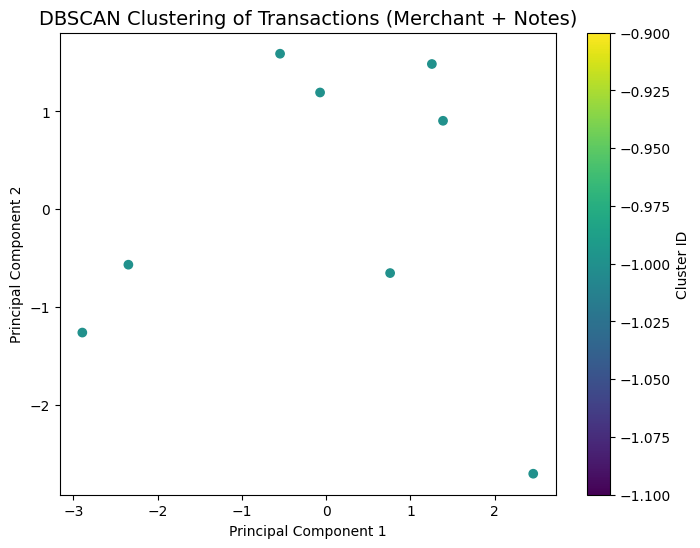

                          Merchant Name  \
0              Chatime - Darmo Surabaya   
1  Grill and Go Spesial Ayam Bakar Madu   
2                        PLN Pascabayar   
3                                  DANA   
4                              BeliCash   
5                             TOKOPEDIA   
6               PT Komunika Lintas Maya   
7                              BANK BRI   

                                      Notes  Amount  Cluster  
0                            GrabFood Order   51000       -1  
1                            GrabFood Order   41500       -1  
2                                         -  255000       -1  
3                                         -   35000       -1  
4  QR Payment Merchant PAN 9360091503474855   11000       -1  
5                         Bought vegetables   48500       -1  
6    Pembelian QRIS PT Komunika Lintas Maya   22000       -1  
7                           Top-up e-wallet   50000       -1  


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Sample data (for testing)
data = {
    'Merchant Name': ["Chatime - Darmo Surabaya", "Grill and Go Spesial Ayam Bakar Madu", "PLN Pascabayar", "DANA",
                      "BeliCash", "TOKOPEDIA", "PT Komunika Lintas Maya", "BANK BRI"],
    'Notes': ["GrabFood Order", "GrabFood Order", "-", "-",
              "QR Payment Merchant PAN 9360091503474855", "Bought vegetables", "Pembelian QRIS PT Komunika Lintas Maya", "Top-up e-wallet"],
    'Amount': [51000, 41500, 255000, 35000, 11000, 48500, 22000, 50000]
}

# Load the data into a DataFrame
df = pd.DataFrame(data)

# 1. Tokenize the Text Data
def tokenize(text):
    return text.lower().split()

df['Merchant_Tokens'] = df['Merchant Name'].apply(tokenize)
df['Notes_Tokens'] = df['Notes'].apply(tokenize)

# 2. Train Word2Vec Model
all_tokens = df['Merchant_Tokens'].tolist() + df['Notes_Tokens'].tolist()

# Flatten the list of tokens into one list for Word2Vec training
flattened_tokens = [token for sublist in all_tokens for token in sublist]

# Train the Word2Vec model on the tokenized data
word2vec_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, sg=0)

# 3. Create Word Vectors for Each Merchant and Notes
def get_average_word2vec(tokens, model, vector_size=100):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Apply the function to get average word vectors for 'Merchant Name' and 'Notes'
df['Merchant_Vector'] = df['Merchant_Tokens'].apply(lambda x: get_average_word2vec(x, word2vec_model))
df['Notes_Vector'] = df['Notes_Tokens'].apply(lambda x: get_average_word2vec(x, word2vec_model))

# Combine the vectors of 'Merchant Name' and 'Notes' into one feature set
df['Combined_Vector'] = df['Merchant_Vector'] + df['Notes_Vector']

# 4. Apply DBSCAN Clustering
scaler = MinMaxScaler()
scaled_vectors = scaler.fit_transform(np.array(df['Combined_Vector'].tolist()))

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
df['Cluster'] = dbscan.fit_predict(scaled_vectors)

# 5. PCA for Visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(scaled_vectors)

# Visualize the clusters using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=df['Cluster'], cmap='viridis', marker='o')
plt.title("DBSCAN Clustering of Transactions (Merchant + Notes)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster ID')
plt.show()

# Output the DataFrame with clusters
print(df[['Merchant Name', 'Notes', 'Amount', 'Cluster']])